In [3]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import geopandas as gpd
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

/home/lulu/.pyenv/versions/3.9.7/envs/study_1_venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
railway = gpd.read_file('../report/figures/all_cities/gis_file/railways_no_duplicate.gpkg')
motorway = gpd.read_file('../report/figures/all_cities/gis_file/motorways_2.gpkg')
regions = gpd.read_file('../data/results/regions/regions.gpkg')

spatial_units = gpd.read_file('../data/processed_data/zones_delineation/PC_Delft.gpkg')
spatial_units = spatial_units.drop(columns = ['Postcode','gemeente','area_ratio'])

# City boundaries.
boundaries = spatial_units.dissolve()


exposure = pd.read_csv('../data/results/exposure/Delft_exposure.csv', usecols= ['id_unit','expos_NW'])
spatial_units = spatial_units.merge(exposure, on = 'id_unit')
average_expos = spatial_units['expos_NW'].mean()
std_expos = spatial_units['expos_NW'].std()

# Color system.
spatial_units['exp_norm'] = 0
spatial_units['exp_norm'] = (spatial_units['expos_NW']-average_expos)/std_expos
color_seg = ['#f7d500','#d65800','#a11096']
spatial_units['color'] = color_seg[1]
spatial_units['color'] = spatial_units['color'].mask(spatial_units['exp_norm'] <= -1/3,color_seg[0])
spatial_units['color'] = spatial_units['color'].mask(spatial_units['exp_norm'] > 1/3,color_seg[2])

spatial_units = spatial_units.dissolve(by = 'color').reset_index()
regions_city = regions.loc[(regions['seg'] == 1) & (regions['city'] == 'Delft')]

motorway_city = motorway.overlay(boundaries, how = 'intersection')
railway_city = railway.overlay(boundaries, how = 'intersection')

water_city = gpd.read_file('../../study_1/data/raw_data/water/water_Delft.gpkg')
water_city = water_city.dissolve().explode(index_parts=True)
water_city = water_city.loc[water_city.area>2e5]

aspect_ratio = (boundaries.bounds['maxy'] - boundaries.bounds['miny']) / \
               (boundaries.bounds['maxx'] - boundaries.bounds['minx'])
aspect_ratio = aspect_ratio.iloc[0]

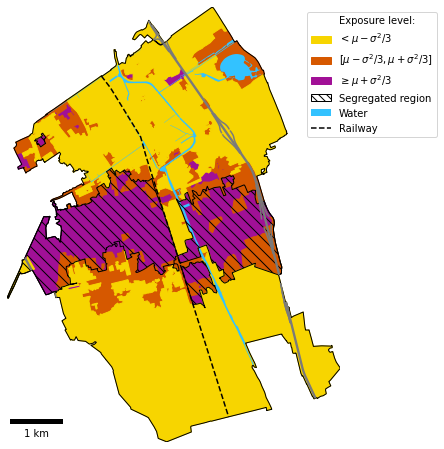

In [62]:
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.margins(0)
spatial_units.plot(ax=ax,color = spatial_units['color'],edgecolor = spatial_units['color'])

ax.axis('off')

water_city.plot(ax = ax, color = '#33c2ff')
railway_city.plot(ax=ax,color = 'black',linestyle = '--')
motorway_city.plot(ax=ax,color = '#7a7a7a')
regions_city.plot(ax=ax,color = 'none',hatch='\\\\')
boundaries.plot(ax=ax,color = 'none', edgecolor = 'black')

# legend
patch_title = mpatches.Patch(color = 'None',label='Exposure level:')
patch_lvl_1 = mpatches.Patch(color=color_seg[0], label='$< \mu - \sigma^2/3$')
patch_lvl_2 = mpatches.Patch(color=color_seg[1], label='$[\mu - \sigma^2/3 , \mu + \sigma^2/3]$')
patch_lvl_3 = mpatches.Patch(color=color_seg[2], label='$\geq \mu + \sigma^2/3$')
patch_region = mpatches.Patch(facecolor='None',edgecolor = 'black',hatch='\\\\\\', label='Segregated region')
patch_water = mpatches.Patch(facecolor='#33c2ff', label='Water')
line_railway = mlines.Line2D([], [], color='black', linestyle='--', label='Railway')
line_motorway = mlines.Line2D([], [], color='#7a7a7a',label='Highway')

if aspect_ratio > 1:
    ax.legend(handles = [patch_title,patch_lvl_1,patch_lvl_2,patch_lvl_3,patch_region,patch_water,line_railway],
                        loc = 'upper right',bbox_to_anchor=(min(1.4, aspect_ratio), 1))
else:
    ax.legend(handles = [patch_title,patch_lvl_1,patch_lvl_2,patch_lvl_3,patch_region,patch_water,line_railway],
                        loc = 'upper left',ncol = 2,bbox_to_anchor=(0, min(1.2,1/aspect_ratio)))

ax.add_artist(ScaleBar(dx =1 ,length_fraction=0.3/aspect_ratio, location = 'lower left'))

fig.savefig('../report/figures/all_cities/Delft.svg',bbox_inches='tight',pad_inches = 0)
#plt.close()